# Imports

In [2]:
!pip install accelerate
!pip install tqdm
!pip install ipywidgets


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached ipywidgets-8.1.3-py3-none-any.whl.metadata (2.4 kB)
  Using cached widgetsnbextension-4.0.11-py3-none-any.whl.metadata (1.6 kB)
  Using cached jupyterlab_widgets-3.0.11-py3-none-any.whl.metadata (4.1 kB)
Using cached ipywidgets-8.1.3-py3-none-any.whl (139 kB)
Using cached jupyterlab_widgets-3.0.11-py3-none-any.whl (214 kB)
Using cached widgetsnbextension-4.0.11-py3-none-any.whl (2.3 MB)



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import accelerate
import re
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import os
import accelerate
from tqdm import tqdm
from huggingface_hub import notebook_login

notebook_login()

---


# Dataset Exploration



In [4]:
df = pd.read_pickle('Datasets/Melody Script/Star-Wars-The-Force-Awakens.pkl')

In [5]:
df

,Scene_Names,Scene_action,Scene_Characters,Scene_Dialogue,Contents,genre,title,emotion
0,INT. TROOP TRANSPORT VEHICLE NIGHT,"TWENTY STORMTROOPERS. Holding on at attention,...",None,None,TWENTY STORMTROOPERS. Holding on at attention...,Heavy Metal,**The Waiting Game**<eos>,Fear and Determination
1,EXT. JAKKU VILLAGE NIGHT,"of a small, peaceful village. Distant sounds o...",None,None,"of a small, peaceful village. Distant sounds...",Electronic Ambient,Whispers of the Past,A sense of unease and wonder.<eos>
2,INT. LARGE HUT NIGHT,ON A HAND a small LEATHER SACK is placed in th...,"[LOR SAN TEKKA, POE, LOR SAN TEKKA, POE, POE]",[This will begin to make things right. I have ...,ON A HAND a small LEATHER SACK is placed in ...,Space Opera,The Force Awakens,"Hope, Determination, Sacrifice<eos>"
3,EXT. LARGE HUT NIGHT,"The men exit fast. Poe moves TO CAMERA, raises...","[POE, LOR SAN TEKKA]","[You have to hide., You have to leave. Go Poe ...","The men exit fast. Poe moves TO CAMERA, raise...",Dark Ambient,Whispers of the Wind,Fear and Uncertainty
4,EXT. JAKKU VILLAGE NIGHT,TRACK FAST with Poe as he and BB8 hurry throug...,None,None,TRACK FAST with Poe as he and BB8 hurry throu...,Hip-Hop/Rap,"""The Village Standoff""<eos>",Fear and Determination
...,...,...,...,...,...,...,...,...
262,EXT. SPACE DAY,The Falcon FLIES through space and BLASTS to L...,None,None,The Falcon FLIES through space and BLASTS to ...,Hard Rock,None,"Excitement, Freedom, Determination<eos>"
263,EXT. AHCHTO DAY,"A pristine and mighty OCEAN. Endless BLUE, dot...",None,None,"A pristine and mighty OCEAN. Endless BLUE, do...",Space Opera,Celestial Symphony,Hope and wonder
264,EXT. AHCHTO ISLAND DAY,"Rey, her staff strapped to her back, begins he...",None,None,"Rey, her staff strapped to her back, begins h...",Indie Folk,None,Determination and resilience
265,EXT. AHCHTO ISLAND STONE STAIRS DAY,Built within the rock and foliage of this idyl...,None,None,Built within the rock and foliage of this idy...,Rock ballad,None,"Determination, perseverance, resilience"


In [6]:
df.iloc[2]['Scene_action']

"ON A HAND a small LEATHER SACK is placed in the palm. The hand closes. Another OLDER HAND covers it. In a primitive HUT, an old explorer, LOR SAN TEKKA, rugged, kind has handed the mysterious sack to POE DAMERON 32, in a pilot's jacket. Poe has charisma, a natural spark"

In [7]:
df.iloc[2]['Scene_Dialogue']

['This will begin to make things right. I have traveled too far, and seen too much, to ignore the despair in the galaxy. Without the Jedi, there can be no balance in the Force.',
 "Well, because of you now we have a chance. The General's been after this for a long time.",
 "The General. To me, she's royalty. Well, she certainly is that.",
 'BB8 ENTERS FRANTIC, BEEPS. Concerned, Poe turns to Lor San Tekka.',
 'We have got company. ']

In [8]:
df.iloc[2]['Contents']

"  ON A HAND a small LEATHER SACK is placed in the palm. The hand closes. Another OLDER HAND covers it. In a primitive HUT, an old explorer, LOR SAN TEKKA, rugged, kind has handed the mysterious sack to POE DAMERON 32, in a pilot's jacket. Poe has charisma, a natural spark LOR SAN TEKKA This will begin to make things right. I have traveled too far, and seen too much, to ignore the despair in the galaxy. Without the Jedi, there can be no balance in the Force. POE Well, because of you now we have a chance. The General's been after this for a long time. LOR SAN TEKKA The General. To me, she's royalty. Well, she certainly is that. POE BB8 ENTERS FRANTIC, BEEPS. Concerned, Poe turns to Lor San Tekka. POE  We have got company. "

---

# Estrazione Caratteristiche per ogni scena


Caratteristiche estratte: Genere Musicale e Emozioni
Opzionale: Titolo della melodia

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b-it")
model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-2b-it",
    torch_dtype=torch.bfloat16,
    max_length = 6100,
    device_map="auto",
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [24]:
prompt = "Imagine you have to write a song about the scene described, describe with 3 words the song which will fit this scene, the musical genre and the main emotion. \n"

In [25]:
path_script = 'Datasets/Scene Script'
scripts = os.listdir(path_script)

In [26]:
scripts

['Avatar.pkl',
 'Avengers,-The-(2012).pkl',
 'Pulp-Fiction.pkl',
 'Star-Wars-The-Phantom-Menace.pkl',
 'Star-Wars-The-Force-Awakens.pkl',
 'Star-Wars-Attack-of-the-Clones.pkl',
 'Star-Wars-A-New-Hope.pkl',
 'Shrek-the-Third.pkl',
 'Star-Wars-Return-of-the-Jedi.pkl',
 'Star-Wars-The-Empire-Strikes-Back.pkl',
 'V-for-Vendetta.pkl',
 'Toy-Story.pkl',
 'Titanic.pkl']

In [27]:
path_script_melody = 'Datasets/Melody Script'
if not os.path.exists(path_script_melody):
  os.mkdir(path_script_melody)

In [ ]:
for script in tqdm(scripts):
  print("\nAnalyzing ",script)
  df = pd.read_pickle(path_script+'/'+script)
  for index, row in df.iterrows():
    # print(index,"of",len(df))
    text = row['Contents']
    input_text = prompt+text
    input_ids = tokenizer(input_text, return_tensors="pt").to('cuda')
    outputs = model.generate(**input_ids, max_new_tokens=100)
    end_output = tokenizer.decode(outputs[0])

    genre = re.findall('Genre:\*\*\s*(.*)', end_output, re.IGNORECASE)
    title = re.findall('Song Title:\*\*\s*(.*)', end_output, re.IGNORECASE)
    emotion = re.findall('Main Emotion:\*\*\s*(.*)', end_output, re.IGNORECASE)

    if genre == []:
      genre = ['None']
    if title == []:
      title = ['None']
    if emotion == []:
      emotion = ['None']
    df.at[index,'genre'] = genre[0]
    df.at[index,'title'] = title[0]
    df.at[index,'emotion'] = emotion[0]

  df.to_pickle(path_script_melody+'/'+script)


100%|██████████| 13/13 [1:36:53<00:00, 447.22s/it]


# Visualizzazione delle caratteristiche estratte

In [ ]:
df = pd.read_pickle('Datasets/Melody Script/Avengers,-The-(2012).pkl')
df

,Scene_Names,Scene_action,Scene_Characters,Scene_Dialogue,Contents,genre,title,emotion
0,"EXT. THRONE ROOM, SPACE ­ NIGHT","Kneeling behind a THRONE, a CLOTHED, ARMORED F...",None,None,"Kneeling behind a THRONE, a CLOTHED, ARMORED ...",Heavy Metal,The Awakening,"Epic, triumphant, and destructive<eos>"
1,EXT. S.H.I.E.L.D. PROJECT P.E.G.A.S.U.S FACILI...,"Out in the NEW MEXICO desert, a remote researc...",None,None,"Out in the NEW MEXICO desert, a remote resear...",Rock,"""Desert Scramble""",Fear and desperation<eos>
2,EXT. HELICOPTER PAD ­ CONTINUOUS,"Standing a few yards from the landing pad, A F...","[NICK FURY, AGENT PHIL COULSON]","[How bad is it?, That's the problem, sir. We d...","Standing a few yards from the landing pad, A ...",Action/Thriller,"""The Shadow of Fear""<eos>",Fear and Determination
3,INT. FACILITY FLOOR ­ NIGHT,Agent Coulson leads Hill and Fury through the ...,"[AGENT PHIL COULSON, NICK FURY, AGENT PHIL COU...",[Dr. Selvig read an energy surge from the Tess...,Agent Coulson leads Hill and Fury through the...,Post-apocalyptic Rock,The Tesseract's Fury,"Fear, Determination, Hope<eos>"
4,"INT. NASA SPACE RADIATION FACILITY, VACUUM CHA...",Fury enters the lab facility where the Tessera...,"[NICK FURY, SELVIG, NICK FURY, SELVIG, NICK FU...","[Talk to me, doctor. DR. ERIK SELVIG emerges f...",Fury enters the lab facility where the Tesser...,Sci-Fi Metal,The Flare,"Fear, Determination, Hope<eos>"
...,...,...,...,...,...,...,...,...
211,INT. SHIELD ANALYTICAL ROOM ­ DAY,"In TV news montage about THE AVENGERS, we see ...","[SENATOR BOYNTON, WAITRESS]",[These so called heroes have to be held respon...,"In TV news montage about THE AVENGERS, we see...",Hard Rock,Hold the Line,"Anger, Determination, Gratitude<eos>"
212,EXT. CENTRAL PARK ­ DAY,"The Avengers take Thor and Loki, who is handcu...",None,None,"The Avengers take Thor and Loki, who is handc...",Epic Rock,Broken Bonds,"Hope, Sacrifice, and Redemption"
213,INT. SHIELD ANALYTICAL ROOM ­ DAY,Fury is facing once more members of the WORLD ...,"[NICK FURY, NICK FURY, NICK FURY, NICK FURY, N...",[I am not currently tracking their whereabouts...,Fury is facing once more members of the WORLD...,Heavy Metal,None,"Anger, Determination, Revenge<eos>"
214,INT. HELICARRIER BRIDGE ­ DAY,"Fury and Agent Hill walk together, toward the ...","[AGENT MARIA HILL, NICK FURY, AGENT MARIA HILL...","[Sir, how does it work now? They have gone the...","Fury and Agent Hill walk together, toward the...",Hard Rock,"""We Will Be Back""<eos>",Determination and Resolve


# Generazione Word Cloud per visualizzazione generi ed emozioni

In [29]:
import os
import re
from tqdm import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
path_script = 'Datasets/Melody Script'
scripts = os.listdir(path_script)
scripts = [script for script in scripts if script.endswith('.pkl')]

In [48]:
scripts

['Avatar.pkl', 'Avengers,-The-(2012).pkl', 'Pulp-Fiction.pkl', 'Star-Wars-The-Phantom-Menace.pkl', 'Star-Wars-The-Force-Awakens.pkl', 'Star-Wars-Attack-of-the-Clones.pkl', 'Star-Wars-A-New-Hope.pkl', 'Shrek-the-Third.pkl', 'Star-Wars-Return-of-the-Jedi.pkl', 'Star-Wars-The-Empire-Strikes-Back.pkl', 'V-for-Vendetta.pkl', 'Toy-Story.pkl', 'Titanic.pkl']


In [31]:
total = pd.DataFrame()
for script in tqdm(scripts):
  df = pd.read_pickle(path_script+'/'+script)
  total = pd.concat([total,df])

100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


## Word Cloud Generi Musicali

In [32]:
genre_counts = total['genre'].groupby(total['genre']).count().sort_values(ascending=False)

In [33]:
genre_counts.index = genre_counts.index.str.replace('**','')

In [34]:
genre_counts.drop(['None'], inplace=True)
genre_counts.drop(['Star Wars'], inplace=True)

In [35]:
genre_wordcloud = WordCloud(repeat=False, background_color='white',width=800, height=600).generate_from_frequencies(genre_counts)

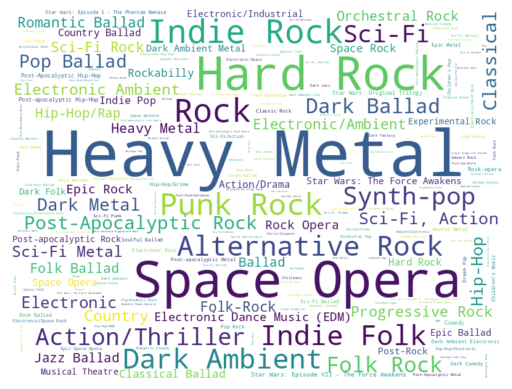

In [36]:
plt.figure()
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
genre_wordcloud.to_file('genre_wordcloud.png')

## Word Cloud Emozioni

In [42]:
emotion_list = total['emotion'].groupby(total['emotion']).count().index.tolist()

In [43]:
emo_texts = ""
for emotion in emotion_list:
  emo_texts = emo_texts + " " + emotion

In [44]:
emo_texts = emo_texts.replace('/',' , ')
emo_texts = emo_texts.replace('**', ' ')
emo_texts = emo_texts.replace('eos',' ')

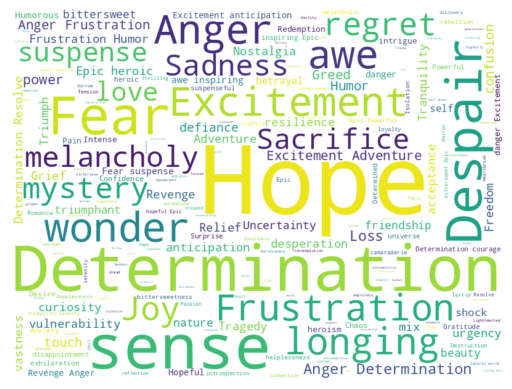

In [47]:
wordcloud = WordCloud(repeat=False,background_color='white',width=800, height=600).generate(emo_texts)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
wordcloud.to_file('emo_wordcloud.png')